In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from data import load_data
from sklearn.model_selection import train_test_split
from Used_Functions import *


data_train_u, data_train_y = load_data(train_test='train', as_tensor=False)
data_train_u, data_test_u, data_train_y, data_test_y = train_test_split(data_train_u,data_train_y, shuffle=False)

u_mean, u_std = np.mean(data_train_u),np.std(data_train_u)
y_mean, y_std = np.mean(data_train_y),np.std(data_train_y)

### Data to train and validate on ###:
utrain = (data_train_u-u_mean)/u_std #normalize
ytrain = (data_train_y-y_mean)/y_std 

uval = (data_test_u-u_mean)/u_std
yval = (data_test_y-y_mean)/y_std

nfuture = 35
n_encode = 20
convert = lambda x: [torch.tensor(xi, dtype=torch.float64) for xi in x]
histtrain, Utrain, Ytrain = convert(make_OE_init_state_data(utrain, ytrain, nf=nfuture,            n_encode=n_encode))
histval,   Uval,   Yval   = convert(make_OE_init_state_data(uval,   yval,   nf=len(uval)-n_encode, n_encode=n_encode))
    
model = simple_encoder_RNN(hidden_size=19, n_encoder=n_encode)
optimizer = torch.optim.Adam(model.parameters())
batch_size = 64
loss_train_list=[]
loss_val_list=[]
best_model= None
best_loss = float('inf')

ids = np.arange(len(Utrain),dtype=int)
for epoch in range(400):
    np.random.shuffle(ids)
    for i in range(0,len(Utrain),batch_size):
        ids_now = ids[i:i+batch_size]
        Uin = Utrain[ids_now]
        histin = histtrain[ids_now]
        Y_real = Ytrain[ids_now]

        Y_predict = model.forward(inputs=Uin, hist=histin)
        residual = Y_real - Y_predict 
        Loss = torch.mean(residual**2) #no burn time
        
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        Loss_val = torch.mean((model(inputs=Uval,hist=histval) - Yval)**2)**0.5
        Loss_train = torch.mean((model(inputs=Utrain,hist=histtrain) - Ytrain)**2)**0.5
        print(f'epoch={epoch}, Validation Loss={Loss_val.item():.2%}, Train Loss={Loss_train.item():.2%}')
    
    if Loss_val < best_loss:
        best_loss = Loss_val
        best_model = model
    



epoch=0, Validation Loss=35.63%, Train Loss=21.37%
epoch=1, Validation Loss=33.74%, Train Loss=17.96%
epoch=2, Validation Loss=32.68%, Train Loss=16.73%
epoch=3, Validation Loss=31.34%, Train Loss=15.81%
epoch=4, Validation Loss=30.49%, Train Loss=15.08%
epoch=5, Validation Loss=31.75%, Train Loss=16.59%
epoch=6, Validation Loss=27.24%, Train Loss=11.24%
epoch=7, Validation Loss=23.87%, Train Loss=8.39%
epoch=8, Validation Loss=22.86%, Train Loss=8.56%
epoch=9, Validation Loss=24.88%, Train Loss=8.95%
epoch=10, Validation Loss=23.87%, Train Loss=10.36%
epoch=11, Validation Loss=23.34%, Train Loss=10.20%
epoch=12, Validation Loss=23.29%, Train Loss=7.66%
epoch=13, Validation Loss=21.38%, Train Loss=6.69%
epoch=14, Validation Loss=21.22%, Train Loss=6.53%
epoch=15, Validation Loss=21.46%, Train Loss=6.08%
epoch=16, Validation Loss=21.82%, Train Loss=6.99%
epoch=17, Validation Loss=22.13%, Train Loss=8.31%
epoch=18, Validation Loss=21.06%, Train Loss=5.76%
epoch=19, Validation Loss=21.64%

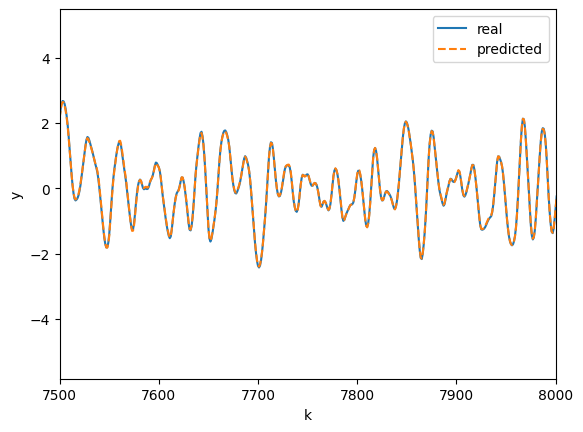

In [8]:
with torch.no_grad():
    plt.plot(Yval[0])
    plt.plot(model(inputs=Uval,hist=histval)[0],'--')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.xlim(7500,8000)
    plt.legend(['real','predicted'])
    plt.show()
    